In [2]:
import re
import os
import sys
import glob
import codecs
import pandas
from subprocess import call
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

            
DATA_DIR = './proj1/'
TRAIN_DATA_DIR=os.path.join(DATA_DIR,'Train')
TEST_DATA_DIR=os.path.join(DATA_DIR,'TestSet')
VALIDATION_DATA_DIR=os.path.join(DATA_DIR,'Validation')

filename_to_word_dict = {}

def open_and_load_res(filename):
    d = {}
    with codecs.open(filename, "r",encoding='utf-8', errors='ignore') as f:
        for line in f:
            words = line.split()
            if(len(words) > 1):
                d[words[0]] = int(words[1])
    
    return d

train_classes = []
validation_classes = []
train_files_as_strings = []
validation_files_as_strings = []

def get_data():
    for z in glob.glob('{}/*/*.zip'.format(DATA_DIR)):
        call(['unzip', z, '-d', '{}'.format(z.replace('.zip','/'))])
        call(['rm', z])
        
    for f in glob.glob('{}/*/*.res'.format(TRAIN_DATA_DIR)):
        matches = re.match(r'(.*)class_(.*)_(.*)', f)
        if not matches:
            print('Error! Could not match class')
            sys.exit(-1)
        clazz = matches.group(2) # Will always be at this index
        file_dict = open_and_load_res(f)
        string = ''
        for (k, v) in file_dict.items():
            for i in range(0, v): string = string +' '+ k
        train_files_as_strings.append(string)
        train_classes.append(clazz)
    
    for f in glob.glob('{}/*/*.res'.format(VALIDATION_DATA_DIR)):
        matches = re.match(r'(.*)class_(.*)_(.*)', f)
        if not matches:
            print('Error! Could not match class')
            sys.exit(-1)
        clazz = matches.group(2) # Will always be at this index
        file_dict = open_and_load_res(f)
        string = ''
        for (k, v) in file_dict.items():
            for i in range(0, v): string = string +' '+ k
        validation_files_as_strings.append(string)
        validation_classes.append(clazz)
    
    x_vectorizer = TfidfVectorizer()
    y_vectorizer = LabelEncoder()
    X_train = x_vectorizer.fit_transform(train_files_as_strings)
    Y_train = y_vectorizer.fit_transform(train_classes)
    X_val = x_vectorizer.transform(validation_files_as_strings)
    Y_val = y_vectorizer.fit_transform(validation_classes)
    return (X_train, Y_train), (X_val, Y_val), x_vectorizer, y_vectorizer

In [3]:
print('Loading data...')
(X_train, y_train), (X_val, y_val), x_vectorizer, y_vectorizer = get_data()

Loading data...


In [5]:
print(X_train[0])

  (0, 44009)	0.169006847597
  (0, 26592)	0.0410922121596
  (0, 50752)	0.0172071761809
  (0, 56319)	0.0819375987242
  (0, 22828)	0.0698161302591
  (0, 7471)	0.0990755271502
  (0, 31984)	0.148939238373
  (0, 46857)	0.0890622789652
  (0, 71223)	0.0369916322146
  (0, 58890)	0.112764322522
  (0, 46895)	0.0652080231203
  (0, 653)	0.148939238373
  (0, 6886)	0.120563850048
  (0, 42725)	0.0167097393396
  (0, 48703)	0.068840835333
  (0, 29914)	0.0947084960793
  (0, 6346)	0.0909942904735
  (0, 56808)	0.103863971001
  (0, 44965)	0.0496973710442
  (0, 50150)	0.0642053320593
  (0, 63528)	0.0166449157232
  (0, 15453)	0.0708521482448
  (0, 38129)	0.297878476746
  (0, 37172)	0.137401861969
  (0, 61231)	0.297878476746
  (0, 66263)	0.105617687905
  (0, 44856)	0.103863971001
  (0, 32005)	0.0166449157232
  (0, 15357)	0.148939238373
  (0, 17338)	0.0540558355088
  (0, 66071)	0.0411177803916
  (0, 57072)	0.0427426364423
  (0, 46916)	0.103863971001
  (0, 41179)	0.744696191864
  (0, 55883)	0.0734052527105


In [88]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier
import numpy as np

print("Fitting clf...")
parameters = {'alpha': (1e-2, 1e-3)}
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42)
gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
gs_clf.fit(X_train, y_train)
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

predicted = gs_clf.predict(X_val)
np.mean(predicted == y_val)

Fitting clf...
alpha: 0.001
Score was [ 0.98158209  0.98118208  0.97878828]


0.85924713584288048

In [13]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC
import numpy as np

print("Fitting clf...")
parameters = {
                'loss': ['hinge', 'squared_hinge'],
                'fit_intercept': (True, False),
                'tol': (1e-4, 1e-5)
             }
clf = LinearSVC(loss='hinge', fit_intercept=True)
gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
gs_clf.fit(X_train, y_train)
gs_clf.predict(X_val)
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

predicted = gs_clf.predict(X_val)
np.mean(predicted == y_val)

Fitting clf...
fit_intercept: False
loss: 'squared_hinge'
tol: 0.0001


0.89525368248772508

In [103]:
from sklearn.grid_search import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
import numpy as np

print("Fitting clf...")
parameters = {
                'alpha': (0.1, 1.0, 10.0)
             }
clf = MultinomialNB()
gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
gs_clf.fit(X_train, y_train)
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

predicted = gs_clf.predict(X_val)
np.mean(predicted == y_val)

Fitting clf...
alpha: 0.1


0.88379705400982

In [93]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

print("Fitting clf...")
parameters = {}
clf = KNeighborsClassifier(n_neighbors=8)
gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
gs_clf.fit(X_train, y_train)
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

predicted = gs_clf.predict(X_val)
np.mean(predicted == y_val)

Fitting clf...


0.76104746317512273

In [5]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import RidgeClassifierCV
import numpy as np

print("Fitting clf...")
parameters = {}
clf = RidgeClassifierCV(fit_intercept=True, normalize=True)
gs_clf = GridSearchCV(clf, parameters, n_jobs=-1)
gs_clf.fit(X_train, y_train)
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

predicted = gs_clf.predict(X_val)
np.mean(predicted == y_val)

Fitting clf...


0.88052373158756136

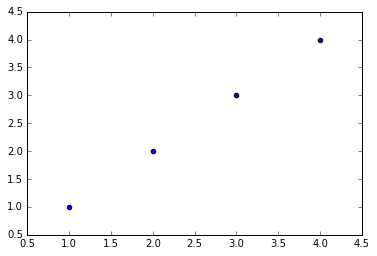

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter([1, 2, 3, 4], [1, 2, 3, 4])
plt.show()